# Tesseroid with Discontinuous Density

**Import Packages**

In [1]:
from __future__ import division
import numpy as np
from tesseroid_density import tesseroid
from fatiando.constants import G, MEAN_EARTH_RADIUS, SI2MGAL, SI2EOTVOS
from fatiando.mesher import Tesseroid, TesseroidMesh
from fatiando import gridder
import matplotlib.pyplot as plt

**Configuration for Pyplot Figures**

In [2]:
%matplotlib inline
plt.rcParams['axes.labelsize'] = 9.0 # fontsize of the x any y labels
plt.rcParams['xtick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['ytick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['legend.fontsize'] = 9.0
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True # use latex for all text handling
plt.rcParams['text.color'] = '3a3a3a'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.edgecolor'] = '3a3a3a'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2

## One discontinuity

Lets consider a spherical shell with internal and external radii $R_1$ and $R_2$, respectively, with a discontinuous density defined as follows:

\begin{equation}
\rho(r') =
    \begin{cases}
    \rho_1 & R_1 \leq r' < R_c \\
    \rho_2 & R_c \leq r' \leq R_2 \\
    \end{cases}
\end{equation}

with $R_c = (R_1 + R_2)/2$ is the centre radius of the shell.

**Definition of discontinuous density**

In [3]:
rho_1, rho_2 = 2900, 2670
thickness = 1000.
R2 = MEAN_EARTH_RADIUS
R1 = R2 - thickness
Rc = R2 - thickness/2.

def discontinuous_density(height):
    r = height + MEAN_EARTH_RADIUS
    if R1 <= r and r < Rc:
        return rho_1
    elif Rc <= r and r <= R2:
        return rho_2

**Analytical solution for spherical shell**

In [4]:
def shell_discontinuous_density(height, R1, R2, Rc, rho_1, rho_2):
    r = height + MEAN_EARTH_RADIUS
    constant = 4/3*np.pi*G*(rho_1*(Rc**3 - R1**3) + rho_2*(R2**3 - Rc**3))
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of shell model**

In [5]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))
model.addprop("density", [discontinuous_density for i in range(model.size)])

** Determination of D for different grids **

In [6]:
shape = (10, 10)
grids = {"pole": gridder.regular((89, 90, 0, 1), shape, z=2e3),
         "equator": gridder.regular((0, 1, 0, 1), shape, z=2e3),
         "260km": gridder.regular((89, 90, 0, 1), shape, z=260e3),
         "30deg": gridder.regular((60, 90, 0, 30), shape, z=2e3)}
fields = 'potential gz gxx gyy gzz'.split()
D_values = np.arange(0.5, 10.5, 0.5)

for field in fields:
    for grid in grids.keys():
        lons, lats, heights = grids[grid]
        analytical = shell_discontinuous_density(heights[0], R1, R2, Rc, 
                                                 rho_1, rho_2)
        diffs = []
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights,
                                               model, ratio=D)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)
        diffs = np.array(diffs)
        np.savez('results/Ddiscontinuous/' + field + '-' + 
                 grid + '-differences.npz',
                 D_values=D_values, diffs=diffs)

tesseroid_density/tesseroid.py:234: RuntimeWarning: Stopped dividing a tesseroid because it's dimensions would be below the minimum numerical threshold (1e-6 degrees or 1e-3 m). Will compute without division. Cannot guarantee the accuracy of the solution.
  warnings.warn(warning_msg, RuntimeWarning)


** Plot Results **

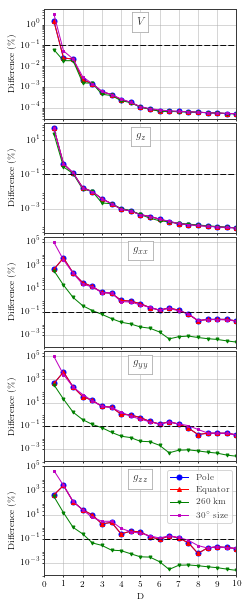

In [7]:
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gxx gyy gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['b', 'r', 'g', 'm']
labels = [r'Pole', r'Equator', r'260 km', r'$30^\circ$ size']
titles = r'$V$ $g_z$ $g_{xx}$ $g_{yy}$ $g_{zz}$'.split()

fig, axes = plt.subplots(nrows=len(fields), ncols=1, sharex=True)
fig.set_size_inches((3.33, 8.33))
fig.subplots_adjust(hspace=0)
for ax, field, title in zip(axes, fields, titles):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/Ddiscontinuous/' + field + '-' + 
                        grid + '-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([0, 10], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

### One discontinuity non symmetrical

Lets consider the last spherical shell but now the discontinuity is not on its centre, but on:

\begin{equation}
R_c = (R_1 + R_2)/3
\end{equation}

**Definition of discontinuous density**

In [8]:
rho_1, rho_2 = 2900, 2670
thickness = 1000.
R2 = MEAN_EARTH_RADIUS
R1 = R2 - thickness
Rc = R2 - thickness/3.

def discontinuous_density(height):
    r = height + MEAN_EARTH_RADIUS
    if R1 <= r and r < Rc:
        return rho_1
    elif Rc <= r and r <= R2:
        return rho_2

**Analytical solution for spherical shell**

In [9]:
def shell_discontinuous_density(height, R1, R2, Rc, rho_1, rho_2):
    r = height + MEAN_EARTH_RADIUS
    constant = 4/3*np.pi*G*(rho_1*(Rc**3 - R1**3) + 
                            rho_2*(R2**3 - Rc**3))
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of shell model**

In [10]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))
model.addprop("density", [discontinuous_density for i in range(model.size)])

** Determination of D for different grids **

In [11]:
shape = (10, 10)
grids = {"pole": gridder.regular((89, 90, 0, 1), shape, z=2e3),
         "equator": gridder.regular((0, 1, 0, 1), shape, z=2e3),
         "260km": gridder.regular((89, 90, 0, 1), shape, z=260e3),
         "30deg": gridder.regular((60, 90, 0, 30), shape, z=2e3)}
fields = 'potential gz gxx gyy gzz'.split()
D_values = np.arange(0.5, 10.5, 0.5)

for field in fields:
    for grid in grids.keys():
        lons, lats, heights = grids[grid]
        analytical = shell_discontinuous_density(heights[0], R1, R2, Rc,
                                                 rho_1, rho_2)
        diffs = []
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights,
                                               model, ratio=D)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)
        diffs = np.array(diffs)
        np.savez('results/Ddiscontinuous/' + field + '-' + 
                 grid + '-asym-differences.npz',
                 D_values=D_values, diffs=diffs)

** Plot Results **

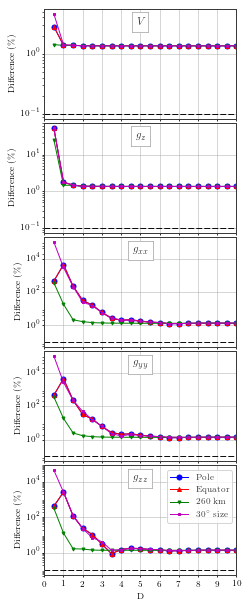

In [12]:
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gxx gyy gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['b', 'r', 'g', 'm']
labels = [r'Pole', r'Equator', r'260 km', r'$30^\circ$ size']
titles = r'$V$ $g_z$ $g_{xx}$ $g_{yy}$ $g_{zz}$'.split()

fig, axes = plt.subplots(nrows=len(fields), ncols=1, sharex=True)
fig.set_size_inches((3.33, 8.33))
fig.subplots_adjust(hspace=0)
for ax, field, title in zip(axes, fields, titles):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/Ddiscontinuous/' + field + '-' + 
                        grid + '-asym-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([0, 10], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()